<a href="https://colab.research.google.com/github/yassine978/Bitcoin-prediction/blob/main/prediction_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.svm import SVR
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA

class CryptocurrencyScraper:
    def __init__(self):
        # Initialize empty lists for storing cryptocurrency data
        self.crypto_date_list = []
        self.crypto_name_list = []
        self.crypto_symbol_list = []
        self.crypto_market_cap_list = []
        self.crypto_price_list = []
        self.crypto_circulating_supply_list = []
        self.crypto_volume_24hr_list = []
        self.crypto_pct_1hr_list = []
        self.crypto_pct_24hr_list = []
        self.crypto_pct_7day_list = []

        # Initialize DataFrame
        self.df = pd.DataFrame()

        # Initialize date list for scraping
        self.scrape_date_list = []

    def scrape_available_dates(self):
        """
        Generate historical dates for scraping from 2014 to the present
        """
        from datetime import datetime, timedelta

        # Start date in 2014
        start_date = datetime(2014, 1, 5)  # First Sunday in 2014
        current_date = datetime.now()

        # Clear any existing dates
        self.scrape_date_list.clear()

        # Generate URLs for each Sunday from 2014 to present
        while start_date <= current_date:
            # Format the date as required by CoinMarketCap historical URL
            date_path = f'/historical/{start_date.strftime("%Y%m%d")}/'
            self.scrape_date_list.append(date_path)

            # Move to next Sunday
            start_date += timedelta(days=7)

        print(f'Generated {len(self.scrape_date_list)} historical dates for scraping from 2014 to present.')

    def scrape_cryptocurrency_data(self, date):
        """
        Scrape cryptocurrency data for a specific date

        :param date: Historical date URL path to scrape
        """
        url = 'https://coinmarketcap.com' + date
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        tr = soup.find_all('tr', attrs={'class': 'cmc-table-row'})
        count = 0
        for row in tr:
            if count == 10:
                break
            count += 1

            try:
                crypto_date = date
                name_column = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sticky cmc-table__cell--sortable cmc-table__cell--left cmc-table__cell--sort-by__name'})
                crypto_name = name_column.find('a', attrs={'class': 'cmc-table__column-name--name cmc-link'}).text.strip()
                crypto_symbol = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--left cmc-table__cell--sort-by__symbol'}).text.strip()
                crypto_market_cap = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__market-cap'}).text.strip()
                crypto_price = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__price'}).text.strip()
                crypto_circulating_supply = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__circulating-supply'}).text.strip().split(' ')[0]

                crypto_voulume_24hr_td = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__volume-24-h'})
                crypto_voulume_24hr = crypto_voulume_24hr_td.find('a', attrs={'class': 'cmc-link'}).text.strip()

                crypto_pct_1hr = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__percent-change-1-h'}).text.strip()
                crypto_pct_24hr = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__percent-change-24-h'}).text.strip()
                crypto_pct_7day = row.find('td', attrs={'class': 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--right cmc-table__cell--sort-by__percent-change-7-d'}).text.strip()

            except AttributeError:
                crypto_date, crypto_name, crypto_symbol = None, None, None
                crypto_market_cap, crypto_price = None, None
                crypto_circulating_supply = None
                crypto_voulume_24hr = None
                crypto_pct_1hr, crypto_pct_24hr, crypto_pct_7day = None, None, None

            self.crypto_date_list.append(crypto_date)
            self.crypto_name_list.append(crypto_name)
            self.crypto_symbol_list.append(crypto_symbol)
            self.crypto_market_cap_list.append(crypto_market_cap)
            self.crypto_price_list.append(crypto_price)
            self.crypto_circulating_supply_list.append(crypto_circulating_supply)
            self.crypto_volume_24hr_list.append(crypto_voulume_24hr)
            self.crypto_pct_1hr_list.append(crypto_pct_1hr)
            self.crypto_pct_24hr_list.append(crypto_pct_24hr)
            self.crypto_pct_7day_list.append(crypto_pct_7day)

    def scrape_all_dates(self):
        """
        Scrape cryptocurrency data for all available dates
        """
        self.scrape_available_dates()

        for i, date in enumerate(self.scrape_date_list):
            self.scrape_cryptocurrency_data(date)
            print(f"Completed: {i+1} out of {len(self.scrape_date_list)}")

    def create_dataframe(self):
        """
        Create DataFrame from scraped data
        """
        self.df['Date'] = self.crypto_date_list
        self.df['Name'] = self.crypto_name_list
        self.df['Symbol'] = self.crypto_symbol_list
        self.df['Market Cap'] = self.crypto_market_cap_list
        self.df['Price'] = self.crypto_price_list
        self.df['Circulating Supply'] = self.crypto_circulating_supply_list
        self.df['Volume (24hr)'] = self.crypto_volume_24hr_list
        self.df['% 1h'] = self.crypto_pct_1hr_list
        self.df['% 24h'] = self.crypto_pct_24hr_list
        self.df['% 7d'] = self.crypto_pct_7day_list

    def clean_data(self):
        """
        Clean and transform the scraped data
        """
        # Extract the date component and convert it to datetime
        self.df['Date'] = pd.to_datetime(self.df['Date'].str.split('/').str[-2], format='%Y%m%d')

        # Replace special characters in specific columns
        self.df['Market Cap'] = self.df['Market Cap'].str.replace('[$,]', '', regex=True)
        self.df['Price'] = self.df['Price'].str.replace('[$,]', '', regex=True)
        self.df['Circulating Supply'] = self.df['Circulating Supply'].str.replace(',', '')
        self.df['Volume (24hr)'] = self.df['Volume (24hr)'].str.replace('[$,]', '', regex=True)

        # Clean percentage columns ('% 1h', '% 24h', '% 7d')
        for col in ['% 1h', '% 24h', '% 7d']:
            self.df[col] = (
                self.df[col]
                .str.replace('--', '0')   # Replace '--' with '0'
                .str.lstrip('>')          # Remove '>'
                .str.lstrip('<')          # Remove '<'
                .str.rstrip('%')          # Remove '%'
            )
            # Handle specific case where value is '<0.01'
            self.df[col] = self.df[col].replace('<0.01', '0')

        # Convert specified columns to numeric, replacing invalid values with NaN
        numeric_cols = ['Market Cap', 'Price', 'Circulating Supply', 'Volume (24hr)', '% 1h', '% 24h', '% 7d']
        self.df[numeric_cols] = self.df[numeric_cols].apply(pd.to_numeric, errors='coerce')

        # Set display format for float and integer values
        pd.options.display.float_format = '{:.2f}'.format
    def clean_data(self):
        """
        Clean and preprocess the scraped data using the original pipeline.
        """
    # Convert date to datetime format
        self.df['Date'] = pd.to_datetime(self.df['Date'].str.split('/').str[-2], format='%Y%m%d', errors='coerce')

    # Replace missing values denoted as '--' with NaN
        self.df.replace('--', np.nan, inplace=True)

    # Remove non-numeric characters from numeric columns
        numeric_cols = ['Market Cap', 'Price', 'Circulating Supply', 'Volume (24hr)', '% 1h', '% 24h', '% 7d']
        for col in numeric_cols:
            self.df[col] = self.df[col].replace(r'[^\d.-]', '', regex=True)

    # Convert percentages to numeric
        percentage_cols = ['% 1h', '% 24h', '% 7d']
        for col in percentage_cols:
            self.df[col] = self.df[col].str.strip('%').astype(float)

    # Convert remaining numeric columns to appropriate types
        self.df['Market Cap'] = pd.to_numeric(self.df['Market Cap'], errors='coerce')
        self.df['Price'] = pd.to_numeric(self.df['Price'], errors='coerce')
        self.df['Circulating Supply'] = pd.to_numeric(self.df['Circulating Supply'], errors='coerce')
        self.df['Volume (24hr)'] = pd.to_numeric(self.df['Volume (24hr)'], errors='coerce')

    # Fill any NaN values with a placeholder if needed, or leave them for later imputation
        print("Data cleaning completed. Missing values summary:")
        print(self.df.isnull().sum())


    def save_to_csv(self, filename='output_f.csv'):
        """
        Save DataFrame to CSV

        :param filename: Output filename
        """
        self.df.to_csv(filename, index=False)
    def impute_missing_values(self):
        """
        Impute missing values in the DataFrame using KNNImputer
        """
        # Check if the DataFrame is empty
        if self.df.empty:
            raise ValueError("DataFrame is empty. Please scrape and clean the data first.")

        # Identify numeric columns
        numeric_cols = ['Market Cap', 'Price', 'Circulating Supply', '% 1h', '% 24h', '% 7d', 'Volume (24hr)']

        # Print initial missing values
        print("Initial missing values:")
        print(self.df[numeric_cols].isnull().sum())

        # Check the percentage of missing values
        missing_percentage = self.df[numeric_cols].isnull().mean() * 100
        print("\nPercentage of missing values:")
        print(missing_percentage)

        # If too many columns have missing values, handle them differently
        if (missing_percentage > 50).any():
            print("\nWarning: Some columns have more than 50% missing values. Dropping these columns.")
            # Drop columns with more than 50% missing values
            columns_to_drop = missing_percentage[missing_percentage > 50].index.tolist()
            numeric_cols = [col for col in numeric_cols if col not in columns_to_drop]
            self.df.drop(columns=columns_to_drop, inplace=True)

        # If still have missing values, try simple imputation first
        if self.df[numeric_cols].isnull().any().any():
            print("\nUsing median imputation for remaining missing values before KNN.")
            self.df[numeric_cols] = self.df[numeric_cols].fillna(self.df[numeric_cols].median())

        # Normalize numeric columns
        scaler = MinMaxScaler()
        df_normalized = self.df.copy()
        df_normalized[numeric_cols] = scaler.fit_transform(self.df[numeric_cols])

        # Try imputation with a small k value
        try:
            best_k = self.find_best_k(df_normalized, numeric_cols, target_column='Price', scaler=scaler)

            # Final imputation with the best k
            final_imputer = KNNImputer(n_neighbors=best_k)
            df_imputed = df_normalized.copy()
            df_imputed[numeric_cols] = final_imputer.fit_transform(df_normalized[numeric_cols])

            # Denormalize the imputed data
            self.df[numeric_cols] = scaler.inverse_transform(df_imputed[numeric_cols])
            print(f"Imputed missing values using KNNImputer with k={best_k}.")

        except Exception as e:
            print(f"KNN Imputation failed: {e}")
            print("Falling back to median imputation.")
            self.df[numeric_cols] = self.df[numeric_cols].fillna(self.df[numeric_cols].median())

        # Final check for any remaining NaNs
        remaining_nans = self.df[numeric_cols].isnull().sum()
        if remaining_nans.any():
            print("\nRemaining NaN values after imputation:")
            print(remaining_nans)
            raise ValueError("Unable to fully impute missing values.")

        return self.df

    def find_best_k(self, df_normalized, numeric_cols, target_column, scaler):
        """
        Perform cross-validation to find the best k for KNNImputer
        """

        # Introduce artificial missing values in the target column for validation
        df_missing = df_normalized.copy()
        missing_fraction = 0.2  # Use 20% of the data
        missing_indices = np.random.choice(df_missing.index, int(len(df_missing) * missing_fraction), replace=False)
        original_values = self.df.copy()  # Keep track of the original values
        df_missing.loc[missing_indices, target_column] = np.nan

        # Test different values of k
        results = {}
        for k in range(2, 11):  # k from 2 to 10
            imputer = KNNImputer(n_neighbors=k)
            imputed_data = df_missing.copy()
            imputed_data[numeric_cols] = imputer.fit_transform(df_missing[numeric_cols])

            # Calculate RMSE for the target column
            rmse = np.sqrt(mean_squared_error(
                original_values.loc[missing_indices, target_column],
                scaler.inverse_transform(imputed_data[numeric_cols])[missing_indices, numeric_cols.index(target_column)]
            ))
            results[k] = rmse

        # Return the best k
        best_k = min(results, key=results.get)
        print(f"Best k found: {best_k}, RMSE: {results[best_k]:.4f}")
        return best_k



    def run(self):
        """
        Run the entire scraping and processing workflow
        """
        self.scrape_all_dates()
        self.create_dataframe()
        self.clean_data()
        self.impute_missing_values()  # Impute missing values
        self.save_to_csv()
        return self.df

In [42]:
class CustomErrorHandler:
    def check_columns(data, required_columns):
        for col in required_columns:
            if col not in data.columns:
                raise ValueError(f"Column '{col}' is missing in the data.")

    def check_empty(data, filter_condition, name):
        filtered_data = data[filter_condition]
        if filtered_data.empty:
            raise ValueError(f"No data available for '{name}'.")
        return filtered_data

    def check_data_length(data, required_length, message):
        if len(data) <= required_length:
            raise ValueError(message)


In [43]:
class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_data(self):
        try:
            self.data = pd.read_csv(self.file_path)
            return self.data
        except FileNotFoundError:
            raise ValueError(f"File '{self.file_path}' not found.")
        except Exception as e:
            raise ValueError(f"An error occurred while loading the data: {e}")

In [44]:
class DataAnalysis:
    def __init__(self, df):
        self.df = df.copy()
        # Convert Date column to datetime if it exists
        if 'Date' in self.df.columns:
            self.df['Date'] = pd.to_datetime(self.df['Date'])

    def time_series_analysis(self, symbol='BTC'):
        crypto_data = self.df[self.df['Symbol'] == symbol]

        # Set the style
        plt.rcParams['axes.edgecolor'] = '#333F4B'
        plt.rcParams['axes.linewidth'] = 0.8
        plt.rcParams['xtick.color'] = '#333F4B'
        plt.rcParams['ytick.color'] = '#333F4B'
        plt.rcParams['text.color'] = '#333F4B'

        # Create subplots
        fig, axs = plt.subplots(3, 1, figsize=(12, 18))

        # Plot Price
        axs[0].plot(crypto_data['Date'], crypto_data['Price'], color='#007acc', alpha=0.7)
        axs[0].set_title(f'{symbol} Price Over Time', fontsize=15, fontweight='black', color='#333F4B')

        # Plot Market Cap
        axs[1].plot(crypto_data['Date'], crypto_data['Market Cap'], color='#007acc', alpha=0.7)
        axs[1].set_title(f'{symbol} Market Cap Over Time', fontsize=15, fontweight='black', color='#333F4B')

        # Plot Volume
        axs[2].plot(crypto_data['Date'], crypto_data['Volume (24hr)'], color='#007acc', alpha=0.7)
        axs[2].set_title(f'{symbol} 24hr Trading Volume Over Time', fontsize=15, fontweight='black', color='#333F4B')

        # Format dates
        date_format = mdates.DateFormatter('%Y')
        for ax in axs:
            ax.xaxis.set_major_formatter(date_format)
            ax.xaxis.set_major_locator(mdates.YearLocator())

        plt.tight_layout()
        plt.show()

    def correlation_analysis(self):
        """Perform correlation analysis on key metrics"""
        correlation_matrix = self.df[['Market Cap', 'Price', 'Circulating Supply',
                                    'Volume (24hr)', '% 1h', '% 24h', '% 7d']].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Matrix Heatmap')
        plt.show()

        return correlation_matrix

    def trend_analysis(self):
        """Calculate growth rates for key metrics"""
        data_sorted = self.df.sort_values(by=['Name', 'Date'])

        growth_rates = data_sorted.groupby('Name').apply(
            lambda x: ((x[['Price', 'Market Cap', 'Volume (24hr)']].iloc[-1] -
                       x[['Price', 'Market Cap', 'Volume (24hr)']].iloc[0]) /
                      x[['Price', 'Market Cap', 'Volume (24hr)']].iloc[0]) * 100
        )

        return growth_rates

    def volatility_analysis(self):
        """Calculate price volatility for each cryptocurrency"""
        data_sorted = self.df.sort_values(by=['Name', 'Date'])
        data_sorted['Price Change'] = data_sorted.groupby('Name')['Price'].pct_change()
        volatility = data_sorted.groupby('Name')['Price Change'].std()

        return volatility

    def comparative_analysis(self, cryptocurrencies=['Bitcoin', 'Ethereum', 'BNB', 'Dogecoin']):
        """
        Compare latest metrics across cryptocurrencies with visualizations

        Parameters:
        cryptocurrencies (list): List of cryptocurrency names to compare

        Returns:
        pandas.DataFrame: Comparative data for selected cryptocurrencies
        """
        # Get the most recent data for each cryptocurrency
        data_sorted = self.df.sort_values(by=['Name', 'Date'])
        most_recent_data = data_sorted.groupby('Name').last()
        comparative_data = most_recent_data[['Price', 'Market Cap', 'Volume (24hr)']]

        # Filter data for specified cryptocurrencies
        filtered_data = comparative_data.loc[comparative_data.index.isin(cryptocurrencies)]

        # Create visualization
        plt.figure(figsize=(12, 5))

        # Plot a barplot for each metric
        metrics = ['Price', 'Market Cap', 'Volume (24hr)']
        for i, metric in enumerate(metrics, 1):
            plt.subplot(1, 3, i)
            sns.barplot(
                y=filtered_data.index,
                x=filtered_data[metric],
                palette='viridis'
            )
            plt.title(f'{metric} Comparison')
            plt.xlabel(metric)
            plt.ylabel('Cryptocurrency')

        plt.tight_layout()
        plt.show()

        return filtered_data

In [45]:
class DataPreprocessor:
    def __init__(self, data, n_steps=30, symbol='BTC'):
        self.data = data
        self.n_steps = n_steps
        self.symbol = symbol
        self.scaler = MinMaxScaler()
        self.X, self.y = None, None

    def preprocess(self):
        # Check required columns
        required_columns = ['Date', 'Symbol', 'Price']
        CustomErrorHandler.check_columns(self.data, required_columns)

        # Convert dates
        self.data['Date'] = pd.to_datetime(self.data['Date'])

        # Filter data for selected symbol
        crypto_data = CustomErrorHandler.check_empty(
            self.data, self.data['Symbol'] == self.symbol, self.symbol
        )

        # Extract and normalize prices
        price_data = crypto_data['Price'].values
        CustomErrorHandler.check_data_length(
            price_data, self.n_steps, "Insufficient data for n_steps."
        )

        price_data_normalized = self.scaler.fit_transform(price_data.reshape(-1, 1))

        # Create X and y
        X, y = [], []
        for i in range(self.n_steps, len(price_data_normalized)):
            X.append(price_data_normalized[i - self.n_steps:i].flatten())
            y.append(price_data_normalized[i])
        self.X = np.array(X)
        self.y = np.array(y).flatten()
        return crypto_data, self.X, self.y, self.scaler

In [46]:
class ModelTrainer:
    def __init__(self, X, y, model_type="GradientBoosting", arima_order=(1, 1, 1)):
        self.X = X
        self.y = y
        self.model_type = model_type
        self.model = None
        self.r2_score = None
        self.mse_score = None
        self.arima_order = arima_order

    def train(self):
        if self.model_type == "GradientBoosting":
            self.model = GradientBoostingRegressor(random_state=42)
        elif self.model_type == "RandomForest":
            self.model = RandomForestRegressor(random_state=42)
        elif self.model_type == "SVR":
            self.model = SVR()
        elif self.model_type == "XGBoost":
            self.model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        elif self.model_type == "ARIMA":
            self.model = self._train_arima()
        else:
            raise ValueError(f"Modèle non supporté : {self.model_type}")

        # Split data and calculate metrics
        if self.model_type == "ARIMA":
            self._calculate_arima_metrics()
        else:  # For scikit-learn models (GradientBoosting, RandomForest, SVR)
            self._calculate_sklearn_metrics()

        # Print all metrics
        self._print_metrics()

        return self.model

    def _calculate_sklearn_metrics(self):
        """Calculate R² and MSE for scikit-learn models"""
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        # Train the model
        self.model.fit(X_train, y_train)

        # Make predictions
        predictions = self.model.predict(X_test)

        # Calculate metrics
        self.r2_score = r2_score(y_test, predictions)
        self.mse_score = mean_squared_error(y_test, predictions)

    def _calculate_arima_metrics(self):
        """Calculate R² and MSE for ARIMA model"""
        # Get the fitted values
        fitted_values = self.model.fittedvalues

        # Calculate metrics
        # For ARIMA, we use the actual values and fitted values
        # Removing NaN values that might be present at the start of fitted values
        actual_values = self.y[~np.isnan(fitted_values)]
        fitted_values = fitted_values[~np.isnan(fitted_values)]

        # Calculate R²
        ss_tot = np.sum((actual_values - np.mean(actual_values)) ** 2)
        ss_res = np.sum((actual_values - fitted_values) ** 2)
        self.r2_score = 1 - (ss_res / ss_tot)

        # Calculate MSE
        self.mse_score = mean_squared_error(actual_values, fitted_values)

    def _train_arima(self):
        """Train ARIMA model"""
        print("Entraînement du modèle ARIMA...")
        model = ARIMA(self.y, order=self.arima_order).fit()
        print("\nRésumé des paramètres ARIMA:")
        print(f"Order (p,d,q): {self.arima_order}")
        return model

    def _print_metrics(self):
        """Print all metrics for the model"""
        print(f"\nMétriques pour le modèle {self.model_type}:")
        print(f"R² Score: {self.r2_score:.4f}")
        print(f"MSE: {self.mse_score:.4f}")
        print(f"RMSE: {np.sqrt(self.mse_score):.4f}")

In [47]:
class Forecasting:
    def __init__(self, model, scaler, n_steps, model_type="RandomForest"):
        self.model = model
        self.scaler = scaler
        self.n_steps = n_steps
        self.model_type = model_type

    def predict_next_days(self, price_data_normalized, days=60):
        future_prices = list(price_data_normalized[-self.n_steps:].flatten())

        if self.model_type == "ARIMA":
            predictions = self.model.forecast(steps=days)
            return self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

        for _ in range(days):
            input_data = np.array(future_prices[-self.n_steps:]).reshape(1, -1)

            if self.model_type == "SVR":
                next_price = self.model.predict(input_data)

            else:  # Gradient Boosting / Random Forest
                next_price = self.model.predict(input_data)

            future_prices.append(next_price[0])

        predictions = self.scaler.inverse_transform(np.array(future_prices[-days:]).reshape(-1, 1))
        return predictions

In [48]:
class Visualization:
    def plot(crypto_data, predictions, future_dates, model_type, symbol):
        # --- Filter data starting from 2024 ---
        crypto_data_filtered = crypto_data[crypto_data['Date'] >= '2024-01-01']

        # Create figure
        plt.figure(figsize=(14, 7))

        # Plot actual data (filtered from 2024)
        plt.plot(crypto_data_filtered['Date'], crypto_data_filtered['Price'],
                 label=f'Actual {symbol} data (from 2024)', color='blue')

        # Plot predictions
        plt.plot(future_dates, predictions,
                 label=f'Predictions ({model_type})', color='red', linestyle='-')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'Price visualization and predictions for {symbol} using {model_type} (2024 and beyond)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [31]:
if __name__ == "__main__":
    scraper = CryptocurrencyScraper()
    df = scraper.run()
    print(df)

Generated 604 historical dates for scraping from 2014 to present.
Completed: 1 out of 604
Completed: 2 out of 604
Completed: 3 out of 604
Completed: 4 out of 604
Completed: 5 out of 604
Completed: 6 out of 604
Completed: 7 out of 604
Completed: 8 out of 604
Completed: 9 out of 604
Completed: 10 out of 604
Completed: 11 out of 604
Completed: 12 out of 604
Completed: 13 out of 604
Completed: 14 out of 604
Completed: 15 out of 604
Completed: 16 out of 604
Completed: 17 out of 604
Completed: 18 out of 604
Completed: 19 out of 604
Completed: 20 out of 604
Completed: 21 out of 604
Completed: 22 out of 604
Completed: 23 out of 604
Completed: 24 out of 604
Completed: 25 out of 604
Completed: 26 out of 604
Completed: 27 out of 604
Completed: 28 out of 604
Completed: 29 out of 604
Completed: 30 out of 604
Completed: 31 out of 604
Completed: 32 out of 604
Completed: 33 out of 604
Completed: 34 out of 604
Completed: 35 out of 604
Completed: 36 out of 604
Completed: 37 out of 604
Completed: 38 out 

In [32]:
loader = DataLoader("output_f.csv")
data_sorted = loader.load_data()
print(data_sorted)

            Date      Name Symbol    Market Cap      Price  \
0     2014-01-05   Bitcoin    BTC  1.137966e+10  933.53000   
1     2014-01-05  Litecoin    LTC  6.599006e+08   26.83000   
2     2014-01-05       XRP    XRP  1.972413e+08    0.02523   
3     2014-01-05  Peercoin    PPC  1.520735e+08    7.23490   
4     2014-01-05      Omni   OMNI  1.108262e+08  178.90000   
...          ...       ...    ...           ...        ...   
6025  2025-07-20    Solana    SOL  9.765785e+10  181.55000   
6026  2025-07-20      USDC   USDC  6.445732e+10    0.99980   
6027  2025-07-20  Dogecoin   DOGE  4.098848e+10    0.27290   
6028  2025-07-20   Cardano    ADA  3.039829e+10    0.85870   
6029  2025-07-20      TRON    TRX  2.977028e+10    0.31420   

      Circulating Supply  Volume (24hr)  % 1h  % 24h   % 7d  
0           1.218992e+07   7.289852e+07  0.25   8.36  25.84  
1           2.459594e+07   2.999503e+07 -0.21   6.49  11.95  
2           7.817890e+09   2.004383e+05  0.27 -10.38  -7.10  
3      

Performing time series analysis for Bitcoin...


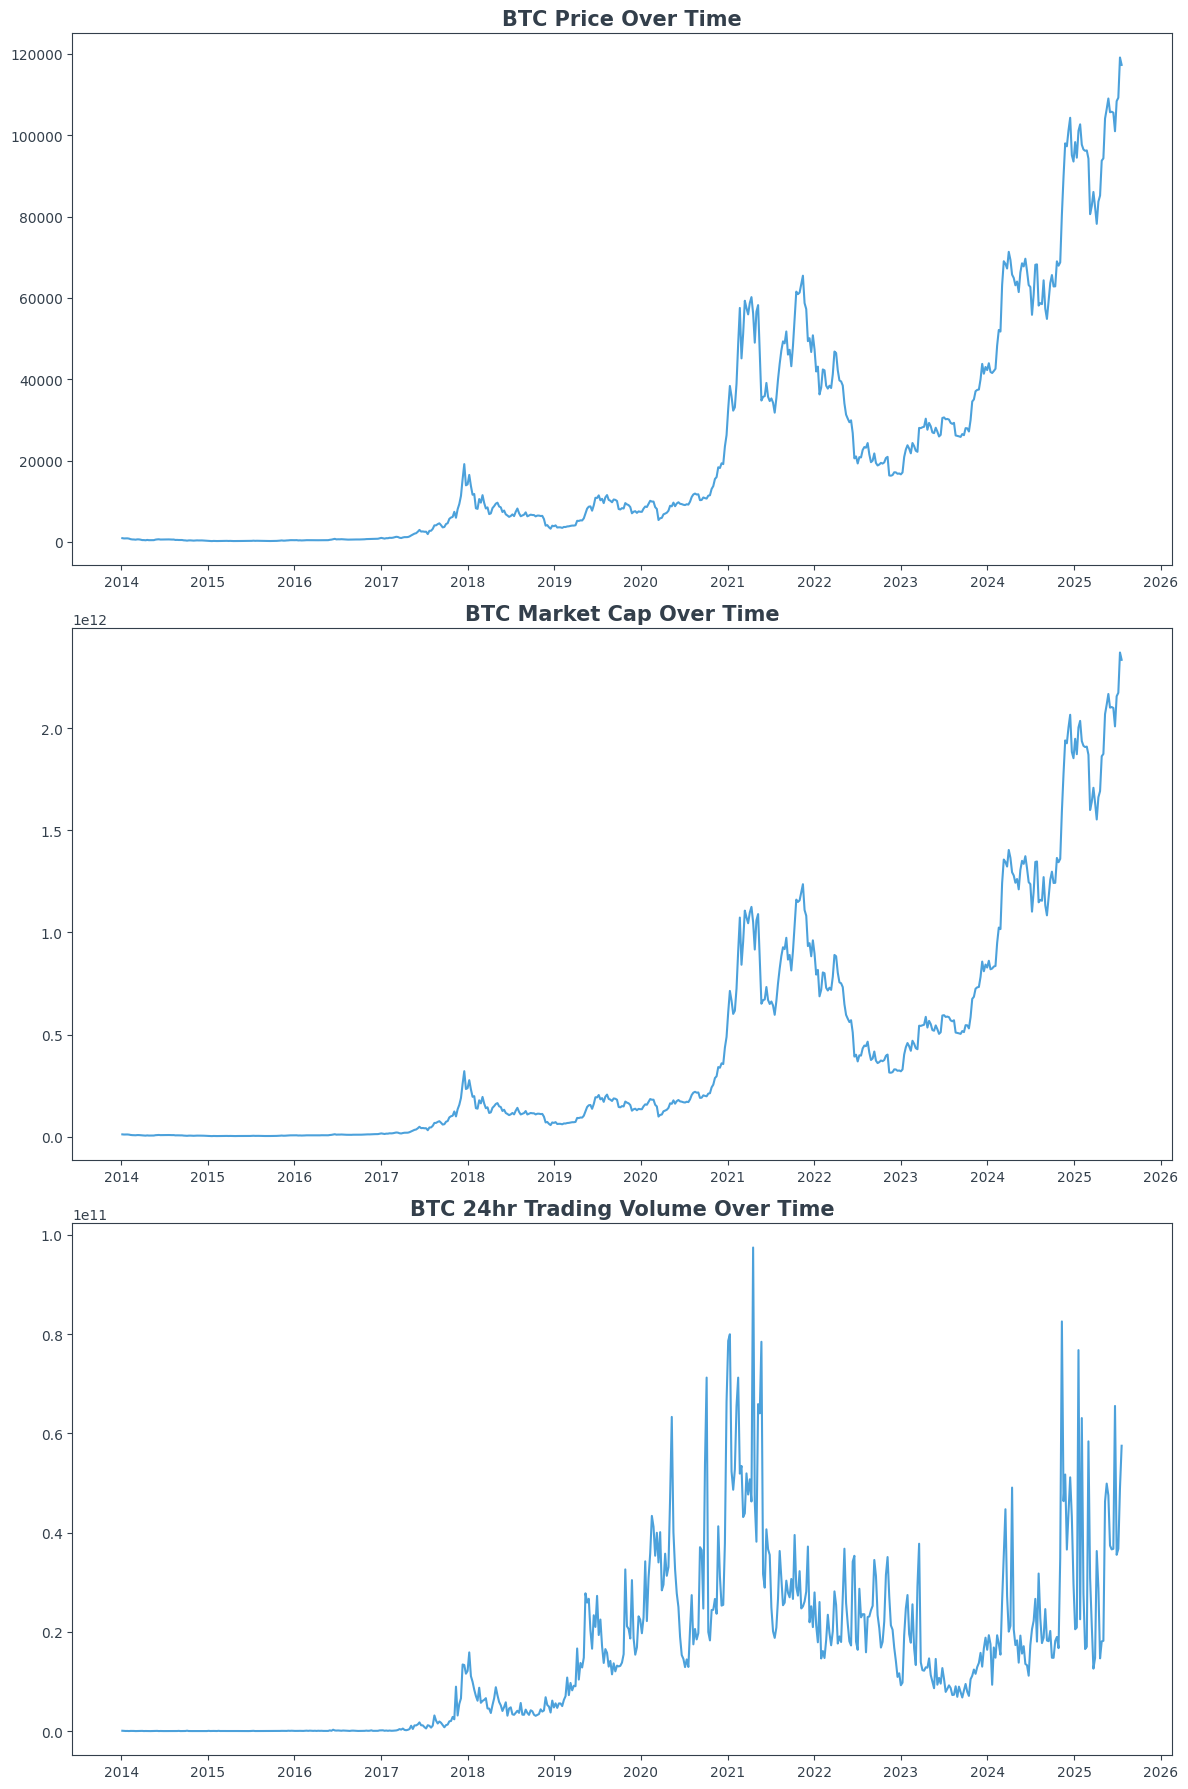


Performing correlation analysis...


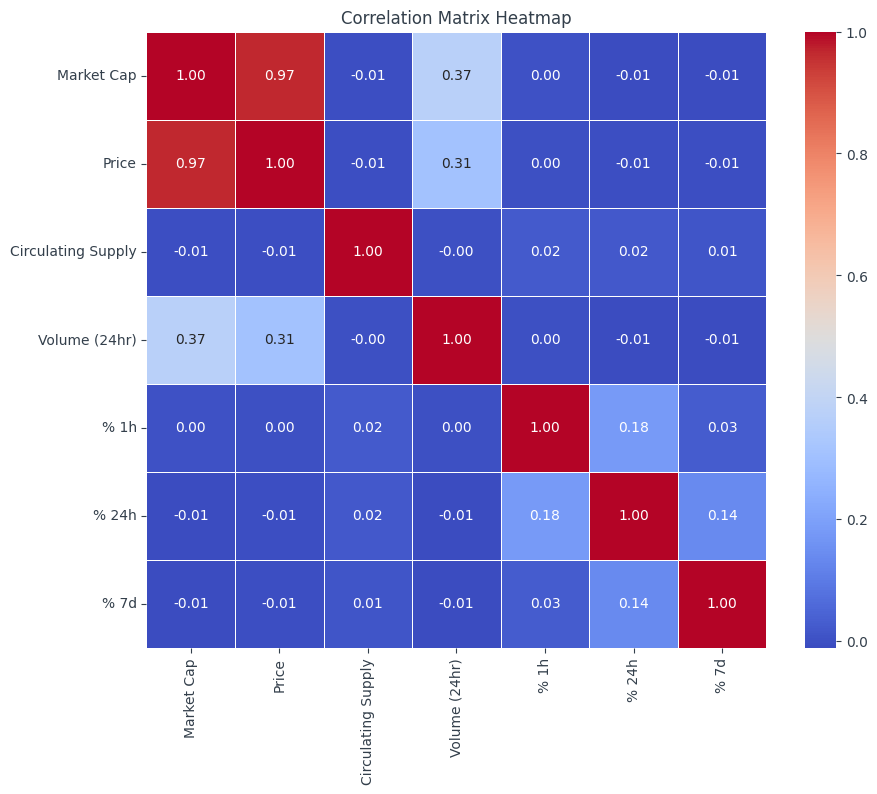


Correlation Matrix:
                    Market Cap     Price  Circulating Supply  Volume (24hr)  \
Market Cap            1.000000  0.968160           -0.005032       0.371735   
Price                 0.968160  1.000000           -0.005189       0.308962   
Circulating Supply   -0.005032 -0.005189            1.000000      -0.000210   
Volume (24hr)         0.371735  0.308962           -0.000210       1.000000   
% 1h                  0.002033  0.000082            0.021724       0.000086   
% 24h                -0.007505 -0.005479            0.018861      -0.010554   
% 7d                 -0.007651 -0.005583            0.010745      -0.007828   

                        % 1h     % 24h      % 7d  
Market Cap          0.002033 -0.007505 -0.007651  
Price               0.000082 -0.005479 -0.005583  
Circulating Supply  0.021724  0.018861  0.010745  
Volume (24hr)       0.000086 -0.010554 -0.007828  
% 1h                1.000000  0.182757  0.026743  
% 24h               0.182757  1.000000  

/tmp/ipython-input-44-276121139.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  growth_rates = data_sorted.groupby('Name').apply(
/tmp/ipython-input-44-276121139.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-44-276121139.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-44-276121139.py:99: FutureWarning: 

Passing `palette` without assigning `hue

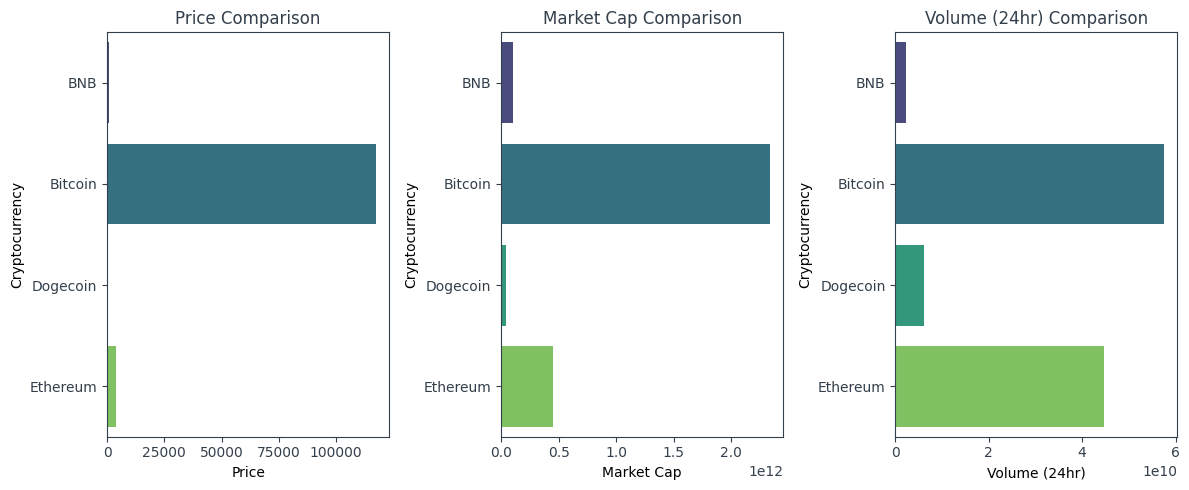


Comparative Data:
                Price    Market Cap  Volume (24hr)
Name                                              
BNB          757.7400  1.055448e+11   2.353254e+09
Bitcoin   117300.7900  2.333710e+12   5.751545e+10
Dogecoin       0.2729  4.098848e+10   6.077967e+09
Ethereum    3759.4700  4.538132e+11   4.460045e+10


In [49]:
if __name__=="__main__":
    try:
        df = pd.read_csv('output_f.csv')

        analyzer = DataAnalysis(df)

        print("Performing time series analysis for Bitcoin...")
        analyzer.time_series_analysis('BTC')

        print("\nPerforming correlation analysis...")
        correlation_matrix = analyzer.correlation_analysis()
        print("\nCorrelation Matrix:")
        print(correlation_matrix)

        print("\nPerforming trend analysis...")
        growth_rates = analyzer.trend_analysis()
        print("\nGrowth Rates:")
        print(growth_rates)

        print("\nPerforming volatility analysis...")
        volatility = analyzer.volatility_analysis()
        print("\nVolatility by Cryptocurrency:")
        print(volatility)

        print("\nPerforming comparative analysis...")
        comparative_data = analyzer.comparative_analysis(['Bitcoin', 'Ethereum', 'BNB', 'Dogecoin'])
        print("\nComparative Data:")
        print(comparative_data)

    except FileNotFoundError:
        print("Error: Data file not found. Please ensure the data file exists and the path is correct.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


1. Loading and preparing data...
Enter cryptocurrency symbol to predict (e.g. BTC, ETH): btc

2. Preprocessing data for BTC...

3. Training and evaluating models...

Testing ARIMA model...
Entraînement du modèle ARIMA...

Résumé des paramètres ARIMA:
Order (p,d,q): (5, 1, 0)

Métriques pour le modèle ARIMA:
R² Score: 0.9877
MSE: 0.0007
RMSE: 0.0262

Making predictions with ARIMA...

Visualizing predictions for ARIMA...


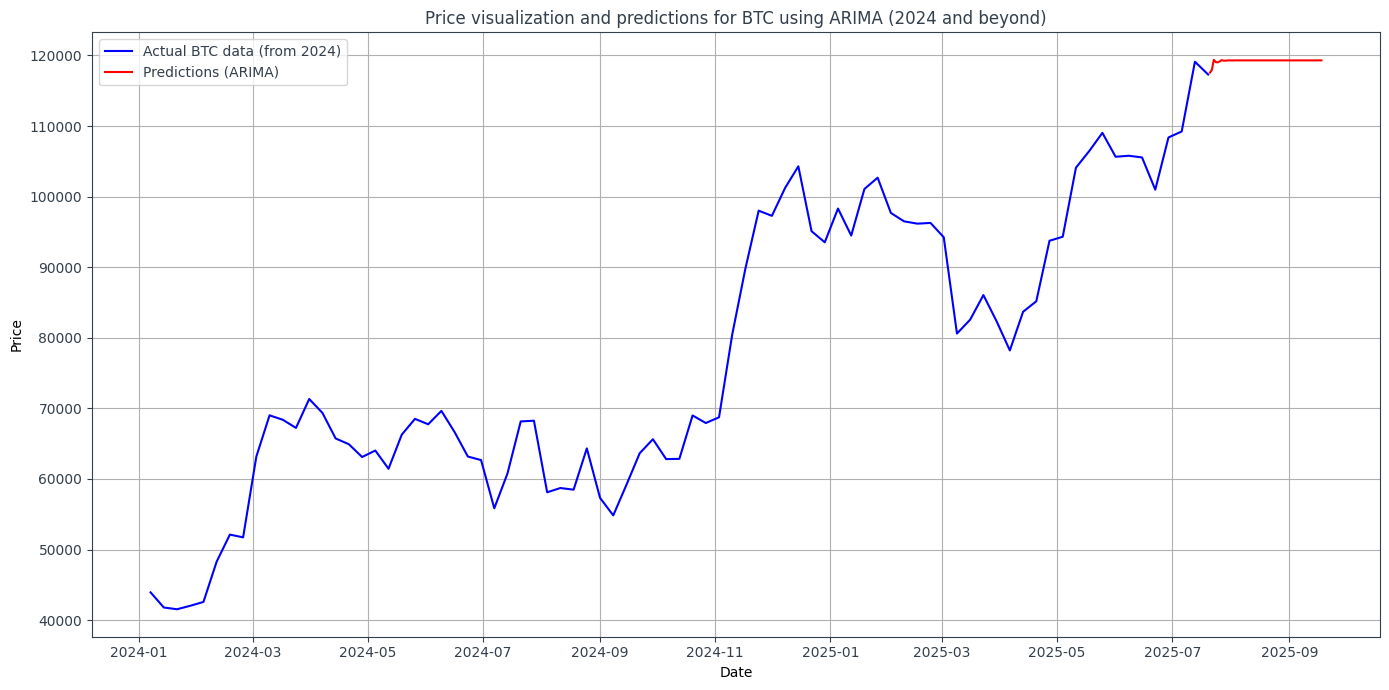


Testing GradientBoosting model...

Métriques pour le modèle GradientBoosting:
R² Score: 0.9879
MSE: 0.0008
RMSE: 0.0276

Making predictions with GradientBoosting...

Visualizing predictions for GradientBoosting...


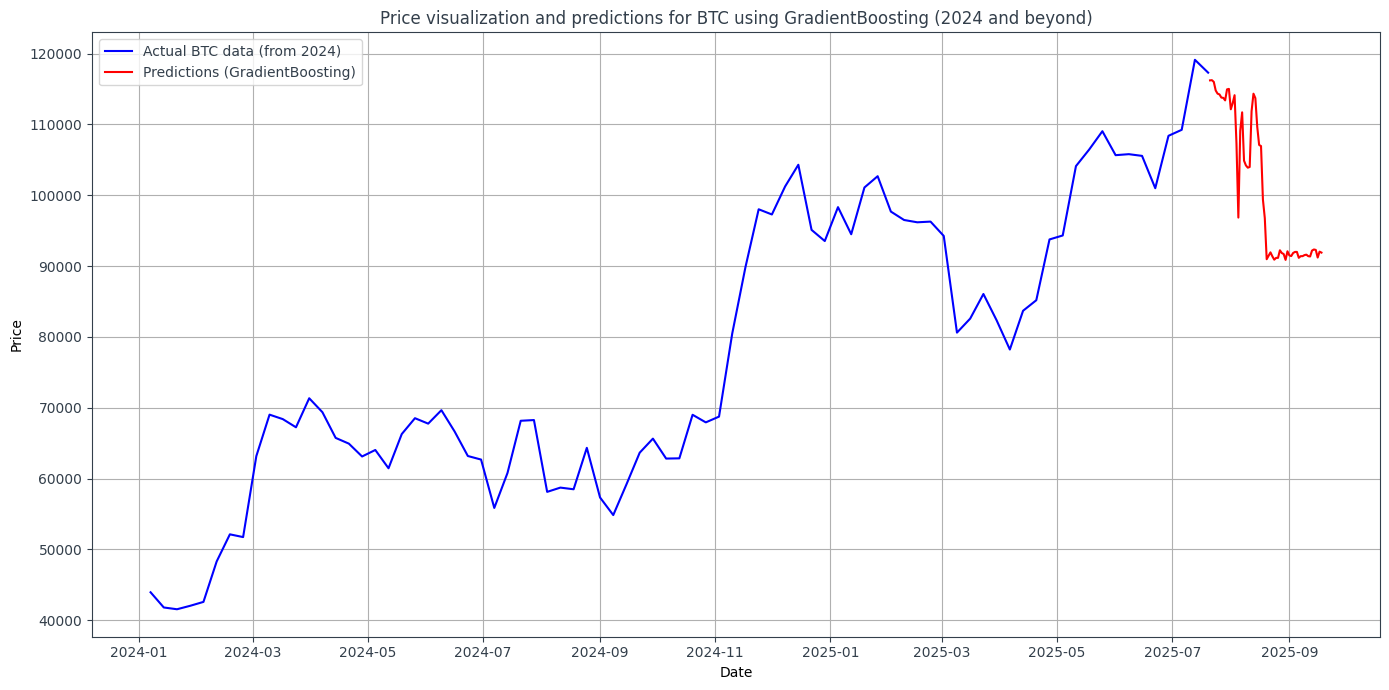


Testing RandomForest model...

Métriques pour le modèle RandomForest:
R² Score: 0.9900
MSE: 0.0006
RMSE: 0.0251

Making predictions with RandomForest...

Visualizing predictions for RandomForest...


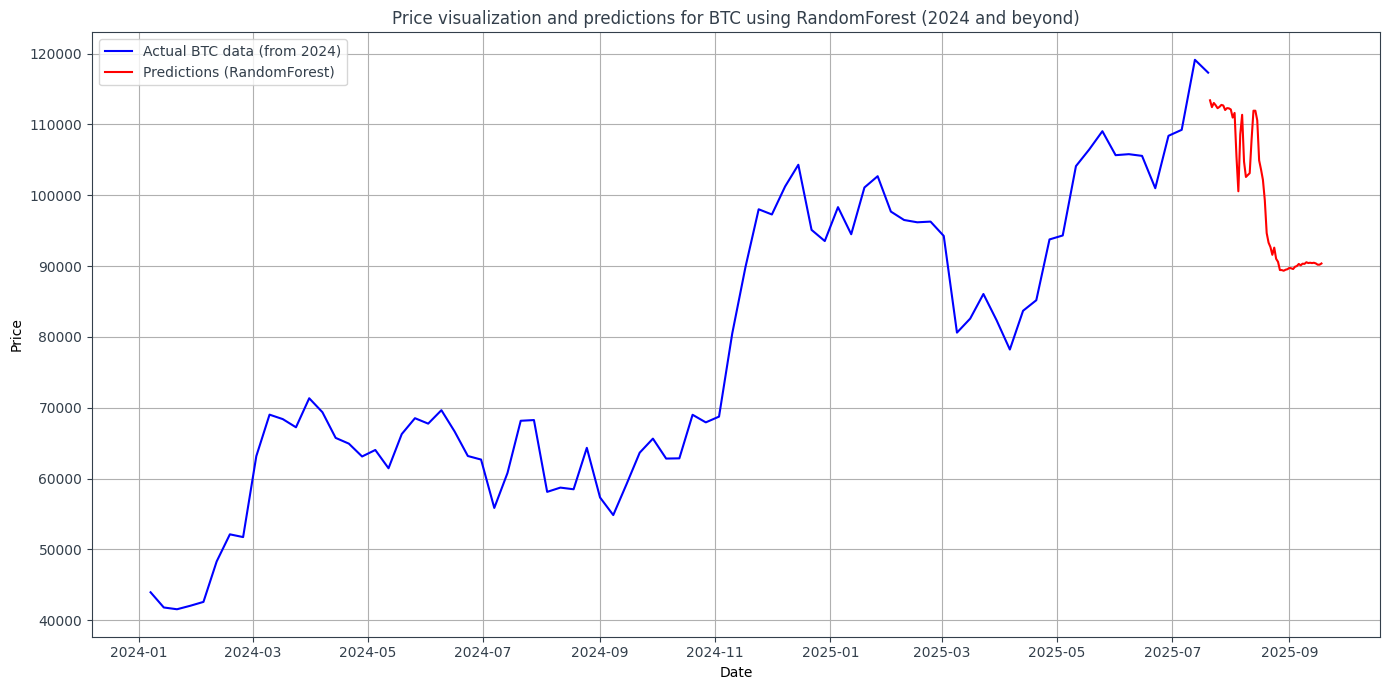


Testing SVR model...

Métriques pour le modèle SVR:
R² Score: 0.9132
MSE: 0.0055
RMSE: 0.0739

Making predictions with SVR...

Visualizing predictions for SVR...


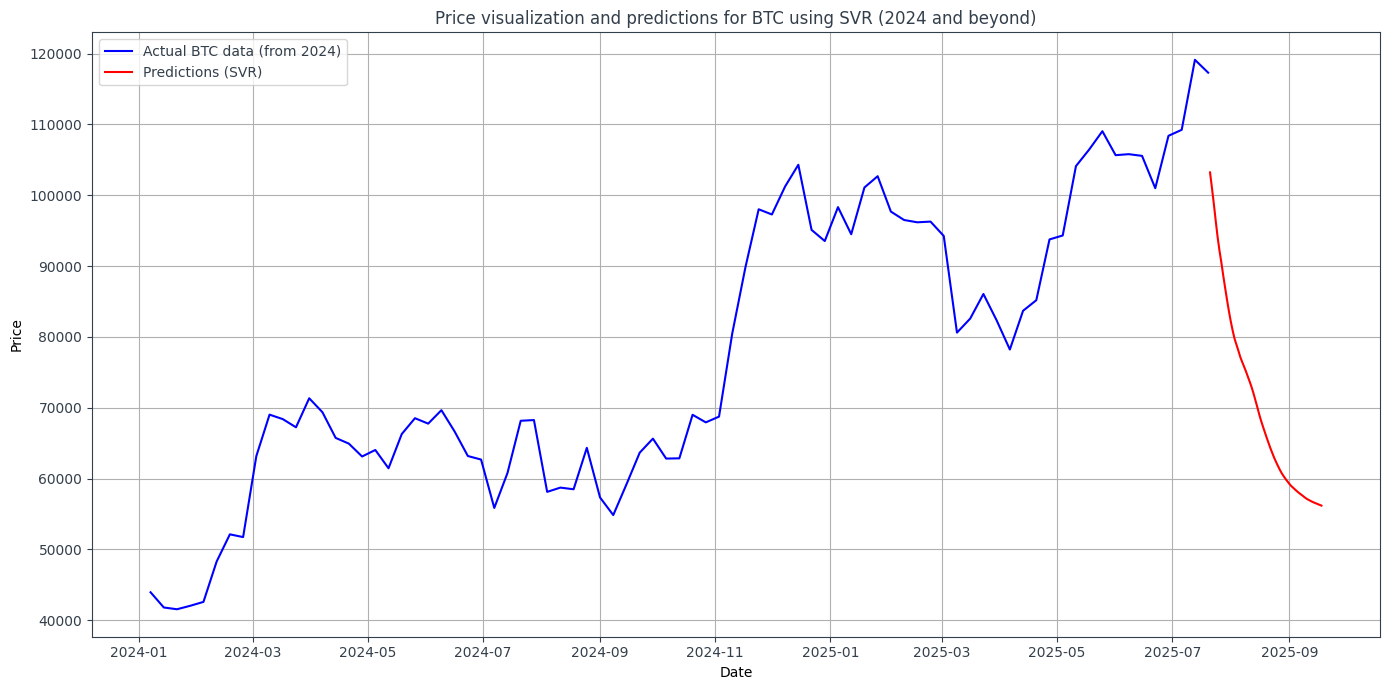


Testing XGBoost model...

Métriques pour le modèle XGBoost:
R² Score: 0.9868
MSE: 0.0008
RMSE: 0.0288

Making predictions with XGBoost...

Visualizing predictions for XGBoost...


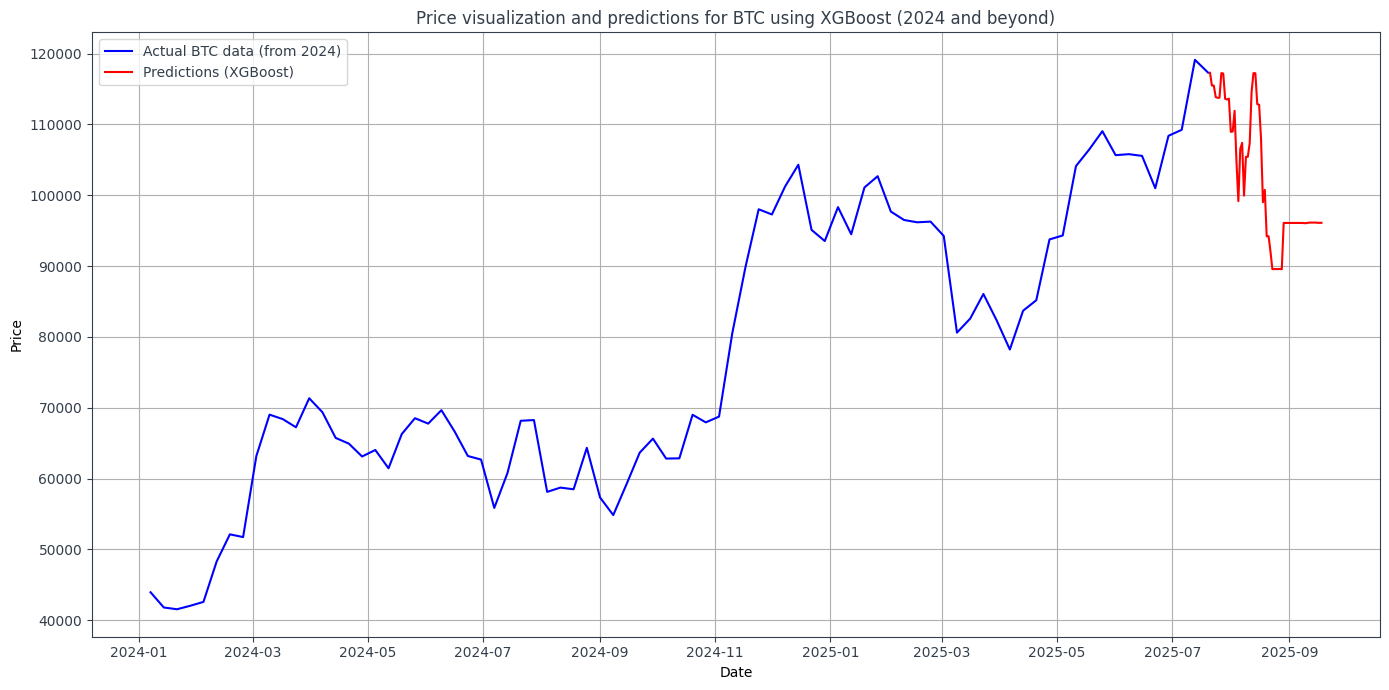


=== Final Results ===
Best performing model: RandomForest
Best MSE score: 0.0006
Best RMSE score: 0.0251


In [50]:
if __name__ == "__main__":
    # 1. Load and prepare data
    print("\n1. Loading and preparing data...")
    loader = DataLoader("output_f.csv")
    data_sorted = loader.load_data()

    # Get user input for cryptocurrency symbol
    symbol = input("Enter cryptocurrency symbol to predict (e.g. BTC, ETH): ").upper()

    # 2. Preprocess data
    print(f"\n2. Preprocessing data for {symbol}...")
    n_steps = 200
    preprocessor = DataPreprocessor(data_sorted, n_steps=n_steps, symbol=symbol)
    crypto_data, X, y, scaler = preprocessor.preprocess()

    # 3. Train and evaluate models
    print("\n3. Training and evaluating models...")

    models_to_test = [
        ("ARIMA", (5, 1, 0)),
        ("GradientBoosting", None),
        ("RandomForest", None),
        ("SVR", None),
        ("XGBoost", None)
    ]

    best_model = None
    best_mse = float('inf')
    best_model_type = None
    best_predictions = None

    for model_type, arima_params in models_to_test:
        print(f"\nTesting {model_type} model...")

        try:
            trainer = ModelTrainer(
                X,
                y,
                model_type=model_type,
                arima_order=arima_params if arima_params else (5, 1, 0)
            )
            model = trainer.train()

            # Store the best model based on MSE
            if trainer.mse_score < best_mse:
                best_mse = trainer.mse_score
                best_model = model
                best_model_type = model_type

            # 4. Make predictions with current model
            print(f"\nMaking predictions with {model_type}...")
            forecasting = Forecasting(model, scaler, n_steps=n_steps, model_type=model_type)
            price_data_normalized = scaler.transform(crypto_data['Price'].values.reshape(-1, 1))
            predictions = forecasting.predict_next_days(price_data_normalized, days=60)

            # 5. Generate future dates
            start_date = crypto_data['Date'].iloc[-1]
            future_dates = [start_date + timedelta(days=i) for i in range(1, 61)]

            # 6. Visualize predictions
            print(f"\nVisualizing predictions for {model_type}...")
            Visualization.plot(crypto_data, predictions, future_dates, model_type, symbol)

        except Exception as e:
            print(f"Error with {model_type} model: {str(e)}")
            continue

    # Print final results
    print("\n=== Final Results ===")
    print(f"Best performing model: {best_model_type}")
    print(f"Best MSE score: {best_mse:.4f}")
    print(f"Best RMSE score: {np.sqrt(best_mse):.4f}")